In [1]:
import numpy as np
import os
import json
import IPython.display as display
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split

First, let's check to see if we have a reasonable number of houses that have images

In [2]:
data_dirs = [d for d in os.listdir() if 'data' in d and os.path.isdir(d)]

In [3]:
num_houses_w_images = 0
for dd in data_dirs:
    houses_found = [d for d in os.listdir(dd) if os.path.isdir('{}/{}'.format(dd,d))]
    for house in houses_found:
        house_content = os.listdir('{}/{}'.format(dd,house))
        if 'gsv_0.jpg' in house_content:
            num_houses_w_images +=1
print(num_houses_w_images)

1933


Great start. Let's make a way to grab the matching price annots and make a dataset

Let's check what the metadata looks like

In [4]:
with open('{}/metadata.json'.format(data_dirs[7])) as test_md:
    md = json.load(test_md)

In [5]:
md['00000']

{'SALE TYPE': 'MLS Listing',
 'SOLD DATE': nan,
 'PROPERTY TYPE': 'Single Family Residential',
 'ADDRESS': '16 S Aberdeen St',
 'CITY': 'Arlington',
 'STATE OR PROVINCE': 'VA',
 'ZIP OR POSTAL CODE': 22204,
 'PRICE': 850000,
 'BEDS': 3,
 'BATHS': 2.0,
 'LOCATION': 'ARLINGTON FOREST',
 'SQUARE FEET': 1716,
 'LOT SIZE': 6385.0,
 'YEAR BUILT': 1940,
 'DAYS ON MARKET': 9,
 '$/SQUARE FEET': 495,
 'HOA/MONTH': nan,
 'STATUS': 'Active',
 'NEXT OPEN HOUSE START TIME': nan,
 'NEXT OPEN HOUSE END TIME': nan,
 'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)': 'http://www.redfin.com/VA/Arlington/16-S-Aberdeen-St-22204/home/11258269',
 'SOURCE': 'BRIGHT MLS',
 'MLS#': 'VAAR170400',
 'FAVORITE': 'N',
 'INTERESTED': 'Y',
 'LATITUDE': 38.8664082,
 'LONGITUDE': -77.114769,
 'image_path': 'data/00000/gsv_0.jpg'}

In [6]:
paths = []
costs = []
years = []
beds = []
baths = []
for dd in data_dirs:
    houses_found = [d for d in os.listdir(dd) if os.path.isdir('{}/{}'.format(dd,d))]
    with open('{}/metadata.json'.format(dd)) as test_md:
        md = json.load(test_md)
    for house in houses_found:
        house_content = os.listdir('{}/{}'.format(dd,house))
        if 'gsv_0.jpg' in house_content:
            try:
                costs.append(md[house]['PRICE']/100000.)
                years.append(md[house]['YEAR BUILT'])
                beds.append(md[house]['BEDS'])
                baths.append(md[house]['BATHS'])
                paths.append('{}/{}/gsv_0.jpg'.format(dd,house))
            except KeyError:
                print(house,dd)
print(len(paths))
print(len(costs))

00046 data_20176
00048 data_20176
00047 data_20176
00049 data_20176
00045 data_20176
1928
1928


In [7]:
print(paths[0],costs[0])

data_22207/00028/gsv_0.jpg 10.95


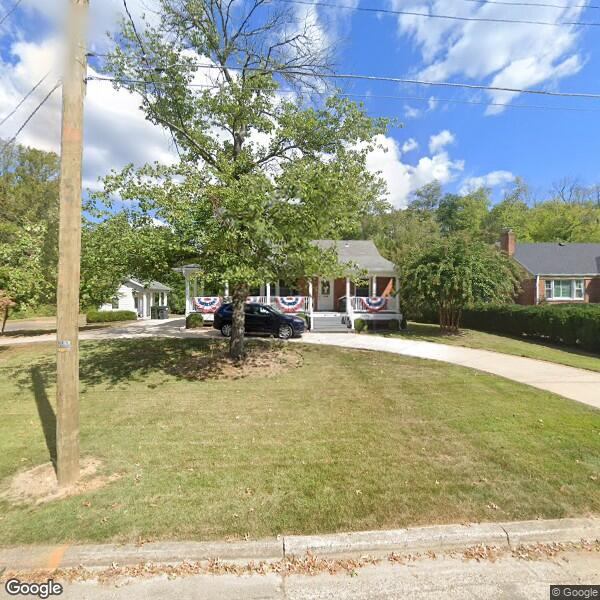

8.25



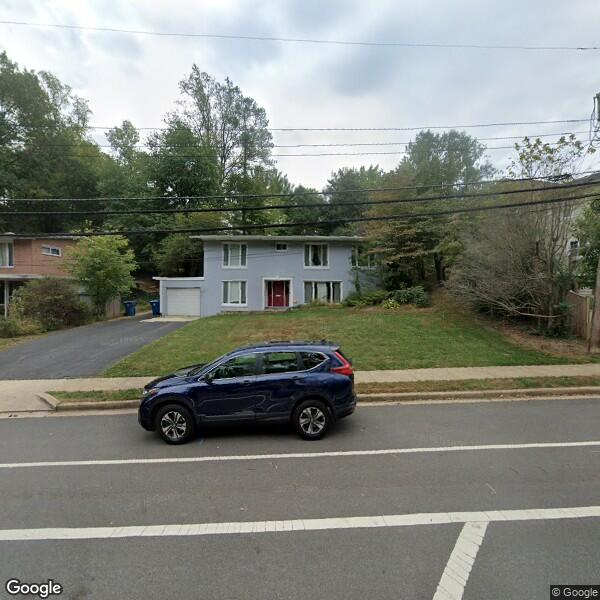

11.249



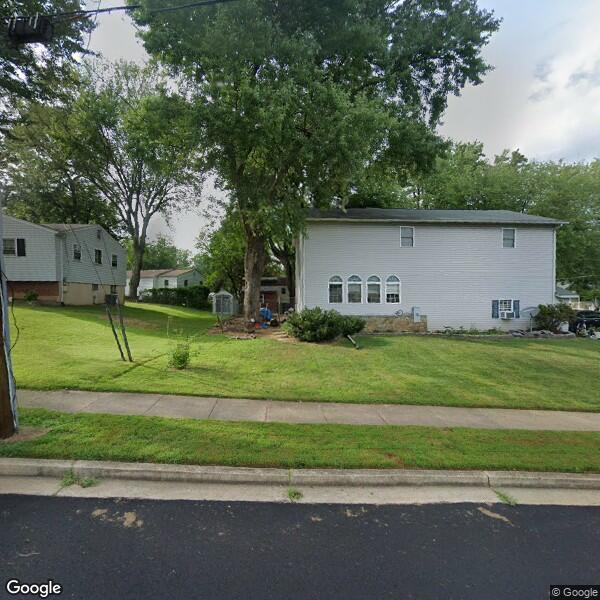

7.99



In [8]:
for n in range(3):
    choice = random.randint(0,len(paths))
    display.display(display.Image(paths[choice]))
    print(costs[choice])
    print()

In [9]:
IM_SIZE = 200

In [10]:
from sklearn.model_selection import train_test_split
train_paths,test_paths,train_labels,test_labels = train_test_split(paths,costs)

In [11]:
def load_and_preprocess(path):
    im = tf.io.read_file(path)
    im = tf.image.decode_jpeg(im,channels=3)
    im = tf.image.resize(im,[IM_SIZE,IM_SIZE])
    im /= 255.0
    return im

In [12]:
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
image_ds = path_ds.map(load_and_preprocess,num_parallel_calls=tf.data.experimental.AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels,tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds,label_ds))

for im,label in image_label_ds.take(2):
    print(im.shape,label)

(200, 200, 3) tf.Tensor(13, shape=(), dtype=int64)
(200, 200, 3) tf.Tensor(21, shape=(), dtype=int64)


In [13]:
train_ds = image_label_ds.shuffle(100)
train_ds = train_ds.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [14]:
path_ds_test = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds_test = path_ds_test.map(load_and_preprocess,num_parallel_calls=tf.data.experimental.AUTOTUNE)
label_ds_test = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels,tf.int64))
image_label_ds_test = tf.data.Dataset.zip((image_ds_test,label_ds_test))
test_ds = image_label_ds_test.shuffle(100)
test_ds = test_ds.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(IM_SIZE, IM_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 156816)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 156817    
Total params: 157,265
Trainable params: 157,265
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [17]:
hist = model.fit(train_ds,validation_data=test_ds,epochs=20,verbose=0)

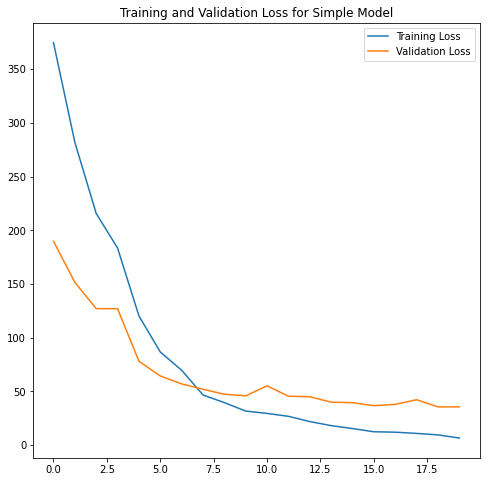

<Figure size 432x288 with 0 Axes>

In [18]:
simple_loss=hist.history['loss']
simple_val_loss=hist.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, simple_loss, label='Training Loss')
plt.plot(epochs_range, simple_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for Simple Model')
plt.show()
plt.savefig('simple.png')

Let's think about what is a better predictor of cost: stats about the house (num beds, num baths, age) vs. appearance

In [19]:
dataset = pd.DataFrame({'yearbuilt':years,'beds':beds,'baths':baths,'cost':costs})
dataset = dataset.dropna()
#dataset['cost'] = dataset['cost'].apply(lambda x: x/100000.)
train_dataset, test_dataset = train_test_split(dataset,test_size=0.2)

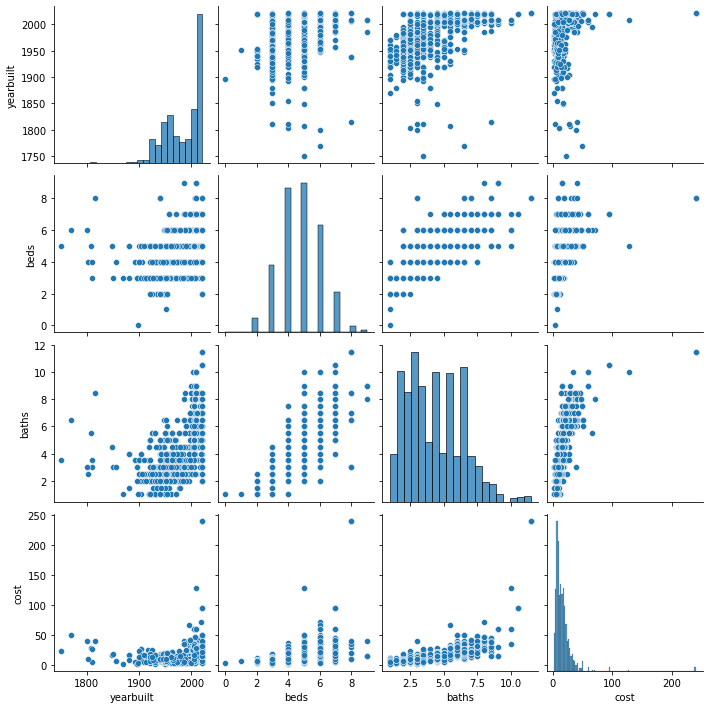

In [20]:
sns.pairplot(train_dataset[['yearbuilt','beds','baths','cost']])

In [21]:
train_dataset.describe().transpose()[['mean','std']]

,mean,std
yearbuilt,1983.938516,37.347385
beds,4.791519,1.298323
baths,4.414488,1.976194
cost,16.599605,18.409344


(array([1.215e+03, 1.740e+02, 1.400e+01, 5.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00]),
 array([  1.999 ,  25.7991,  49.5992,  73.3993,  97.1994, 120.9995,
        144.7996, 168.5997, 192.3998, 216.1999, 240.    ]),
 <BarContainer object of 10 artists>)

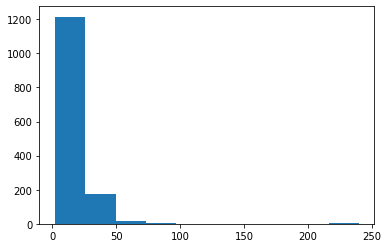

In [22]:
plt.hist(train_dataset['cost'])

In [23]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('cost')
test_labels = test_features.pop('cost')

In [24]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(train_features.head())
print(np.array(train_features)[:5])
print(normalizer.mean.numpy())

      yearbuilt  beds  baths
1403     2004.0     3    3.5
327      2000.0     6    7.0
384      1919.0     3    4.5
332      2005.0     5    7.0
208      2020.0     6    6.5
[[2004.     3.     3.5]
 [2000.     6.     7. ]
 [1919.     3.     4.5]
 [2005.     5.     7. ]
 [2020.     6.     6.5]]
[1983.9385       4.7915196    4.414488 ]


In [25]:
first = np.array(train_features[:1])
with np.printoptions(precision=2,suppress=True):
    print(first)
    print(normalizer(first).numpy())

[[2004.     3.     3.5]]
[[ 0.54 -1.38 -0.46]]


Let's see if we can just predict cost from number of bedrooms

In [26]:
bedrooms = np.array(train_features['beds'])
bed_normalizer = preprocessing.Normalization(input_shape=[1,])
bed_normalizer.adapt(bedrooms)

In [27]:
bed_model = tf.keras.Sequential([bed_normalizer,layers.Dense(units=1)])
bed_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [28]:
bed_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error',metrics=['MAE'])
bed_linear_hist = bed_model.fit(train_features['beds'],train_labels,epochs=20,validation_split=0.2,verbose=0)

In [29]:
bed_hist = pd.DataFrame(bed_linear_hist.history)
bed_hist['epoch'] = bed_linear_hist.epoch
bed_hist.tail()

,loss,MAE,val_loss,val_MAE,epoch
15,6.727281,6.727281,6.051497,6.051497,15
16,6.729527,6.729527,6.051672,6.051672,16
17,6.732768,6.732768,6.043489,6.043489,17
18,6.729743,6.729743,6.036625,6.036625,18
19,6.725501,6.725501,6.054178,6.054178,19


Text(0.5, 1.0, 'Linear model on number of bedrooms training history')

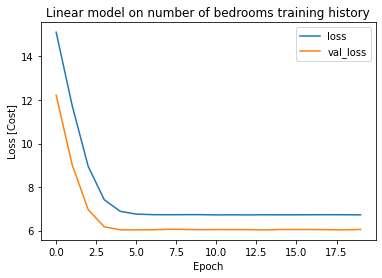

In [76]:
e_range = range(20)
plt.plot(e_range,bed_linear_hist.history['loss'], label='loss')
plt.plot(e_range,bed_linear_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [Cost]')
plt.legend()
plt.title('Linear model on number of bedrooms training history')

In [31]:
test_results = {}
test_results['bed_linear'] = bed_model.evaluate(test_features['beds'],test_labels,verbose=0)

In [32]:
x = tf.linspace(0.0,10,101)
y = bed_model.predict(x)

Text(0.5, 1.0, 'Number of bedrooms v. Cost')

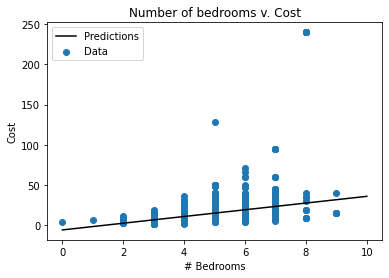

In [75]:
plt.scatter(train_features['beds'],train_labels,label='Data')
plt.plot(x,y,color='k',label='Predictions')
plt.xlabel('# Bedrooms')
plt.ylabel('Cost')
plt.legend()
plt.title('Number of bedrooms v. Cost')

In [34]:
linear_model = tf.keras.Sequential([normalizer,layers.Dense(units=1)])
linear_model.layers[1].kernel

<tf.Variable 'dense_2/kernel:0' shape=(3, 1) dtype=float32, numpy=
array([[ 0.37998915],
       [-1.1921908 ],
       [ 0.5060358 ]], dtype=float32)>

In [35]:
linear_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error',metrics=['MAE'])
lin_hist = linear_model.fit(train_features,train_labels,epochs=20,verbose=0,validation_split=0.2)

Text(0.5, 1.0, 'Linear numerical model training history')

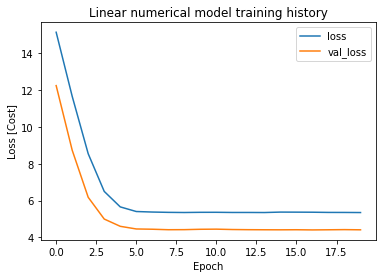

In [74]:
plt.plot(e_range,lin_hist.history['loss'], label='loss')
plt.plot(e_range,lin_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [Cost]')
plt.legend()
plt.title('Linear numerical model training history')

In [37]:
test_results['linear_all'] = linear_model.evaluate(test_features,test_labels,verbose=0)

In [38]:
deeper_model = tf.keras.Sequential([normalizer,layers.Dense(64, activation='relu'),layers.Dense(64,activation='relu'),layers.Dense(1)])
deeper_model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001),metrics=['MAE'])
deeper_hist = deeper_model.fit(train_features,train_labels,epochs=20,verbose=0,validation_split=0.2)

Text(0.5, 1.0, 'Deeper numerical model training history')

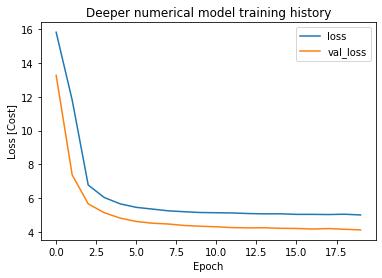

In [73]:
plt.plot(e_range,deeper_hist.history['loss'], label='loss')
plt.plot(e_range,deeper_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [Cost]')
plt.legend()
plt.title('Deeper numerical model training history')

In [40]:
test_results['deeper_all'] = deeper_model.evaluate(test_features,test_labels,verbose=0)

Text(0.5, 1.0, 'Numerical model performance comparison')

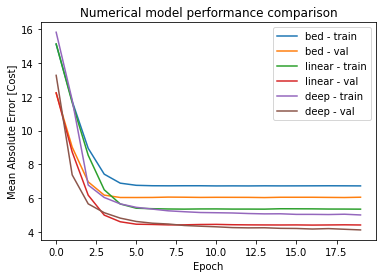

In [72]:
for train_hist,nm in [(bed_linear_hist.history,'bed'),(lin_hist.history,'linear'),(deeper_hist.history,'deep')]:
    plt.plot(e_range,train_hist['MAE'], label='{} - train'.format(nm))
    plt.plot(e_range,train_hist['val_MAE'],label='{} - val'.format(nm))
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error [Cost]')
plt.legend()
plt.title('Numerical model performance comparison')

## Data regression summary

So the models involving all three variables (as opposed to just # of bedrooms) outperform the one variable. The deeper model slightly outperforms its shallower counterpart.

# Vision part

In [42]:
v_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IM_SIZE,IM_SIZE,3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [43]:
v_model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001),metrics=['MAE'])
v_hist = v_model.fit(train_ds,epochs=20,validation_data=test_ds)

Epoch 1/20
46/46 [==============================] - 1s 14ms/step - loss: 27.0246 - MAE: 27.0246 - val_loss: 7.8583 - val_MAE: 7.8583
Epoch 2/20
46/46 [==============================] - 1s 14ms/step - loss: 8.8163 - MAE: 8.8163 - val_loss: 6.9945 - val_MAE: 6.9945
Epoch 3/20
46/46 [==============================] - 1s 14ms/step - loss: 7.7228 - MAE: 7.7228 - val_loss: 6.8905 - val_MAE: 6.8905
Epoch 4/20
46/46 [==============================] - 1s 13ms/step - loss: 8.3679 - MAE: 8.3679 - val_loss: 6.3698 - val_MAE: 6.3698
Epoch 5/20
46/46 [==============================] - 1s 13ms/step - loss: 7.0341 - MAE: 7.0341 - val_loss: 6.6281 - val_MAE: 6.6281
Epoch 6/20
46/46 [==============================] - 1s 14ms/step - loss: 6.9459 - MAE: 6.9459 - val_loss: 6.0960 - val_MAE: 6.0960
Epoch 7/20
46/46 [==============================] - 1s 13ms/step - loss: 6.7087 - MAE: 6.7087 - val_loss: 6.2582 - val_MAE: 6.2582
Epoch 8/20
46/46 [==============================] - 1s 13ms/step - loss: 6.5502 -

In [44]:
print(v_hist.history.keys())

dict_keys(['loss', 'MAE', 'val_loss', 'val_MAE'])


Text(0.5, 1.0, 'Single dense layer image model training history')

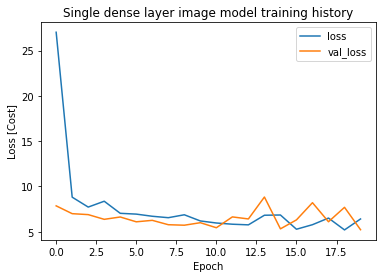

In [71]:
plt.plot(e_range,v_hist.history['loss'], label='loss')
plt.plot(e_range,v_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [Cost]')
plt.legend()
plt.title('Single dense layer image model training history')

In [80]:
test_results['visual_single'] = v_model.evaluate(test_ds,verbose=0)

In [58]:
deepv_model = models.Sequential()
deepv_model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(IM_SIZE,IM_SIZE,3)))
deepv_model.add(layers.MaxPooling2D((2,2)))
deepv_model.add(layers.Conv2D(32,(3,3),activation='relu'))
deepv_model.add(layers.MaxPooling2D((2,2)))
deepv_model.add(layers.Flatten())
deepv_model.add(layers.Dense(64,activation='relu'))
deepv_model.add(layers.Dense(1))
deepv_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 198, 198, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 97, 97, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4718656   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [59]:
deepv_model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001),metrics=['MAE'])
deepv_hist = deepv_model.fit(train_ds,epochs=50,validation_data=test_ds)

Epoch 1/50
46/46 [==============================] - 1s 32ms/step - loss: 9.0982 - MAE: 9.0982 - val_loss: 7.2343 - val_MAE: 7.2343
Epoch 2/50
46/46 [==============================] - 1s 30ms/step - loss: 8.2447 - MAE: 8.2447 - val_loss: 6.7699 - val_MAE: 6.7699
Epoch 3/50
46/46 [==============================] - 1s 30ms/step - loss: 7.2226 - MAE: 7.2226 - val_loss: 6.0199 - val_MAE: 6.0199
Epoch 4/50
46/46 [==============================] - 1s 30ms/step - loss: 6.6103 - MAE: 6.6103 - val_loss: 5.6222 - val_MAE: 5.6222
Epoch 5/50
46/46 [==============================] - 1s 31ms/step - loss: 5.3339 - MAE: 5.3339 - val_loss: 5.0518 - val_MAE: 5.0518
Epoch 6/50
46/46 [==============================] - 1s 30ms/step - loss: 4.5330 - MAE: 4.5330 - val_loss: 4.6886 - val_MAE: 4.6886
Epoch 7/50
46/46 [==============================] - 1s 30ms/step - loss: 4.0588 - MAE: 4.0588 - val_loss: 4.3616 - val_MAE: 4.3616
Epoch 8/50
46/46 [==============================] - 1s 31ms/step - loss: 3.8786 - M

Text(0.5, 1.0, 'Deep visual model training history')

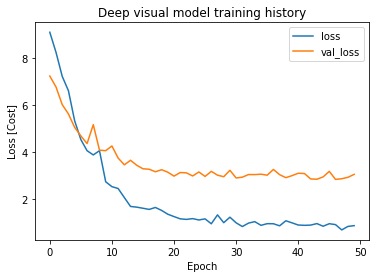

In [70]:
plt.plot(range(50),deepv_hist.history['loss'], label='loss')
plt.plot(range(50),deepv_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [Cost]')
plt.legend()
plt.title('Deep visual model training history')

In [81]:
test_results['visual_deep'] = deepv_model.evaluate(test_ds,verbose=0)

In [49]:
vgg = tf.keras.applications.VGG16(input_shape=(IM_SIZE,IM_SIZE,3),include_top=False,weights='imagenet')

In [50]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [51]:
vgg.trainable = False

In [52]:
ft = models.Sequential()
ft.add(vgg)
ft.add(layers.Flatten())
ft.add(layers.Dense(64,activation='relu'))
ft.add(layers.Dense(1))
ft.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                1179712   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 15,894,465
Trainable params: 1,179,777
Non-trainable params: 14,714,688
_________________________________________________________________


In [53]:
ft.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001),metrics=['MAE'])
ft_hist = ft.fit(train_ds,epochs=50,validation_data=test_ds)

Epoch 1/50
46/46 [==============================] - 5s 99ms/step - loss: 8.0139 - MAE: 8.0139 - val_loss: 6.1017 - val_MAE: 6.1017
Epoch 2/50
46/46 [==============================] - 4s 83ms/step - loss: 6.6461 - MAE: 6.6461 - val_loss: 5.8096 - val_MAE: 5.8096
Epoch 3/50
46/46 [==============================] - 4s 83ms/step - loss: 5.6057 - MAE: 5.6057 - val_loss: 5.5829 - val_MAE: 5.5829
Epoch 4/50
46/46 [==============================] - 4s 82ms/step - loss: 5.5429 - MAE: 5.5429 - val_loss: 5.6842 - val_MAE: 5.6842
Epoch 5/50
46/46 [==============================] - 4s 83ms/step - loss: 4.9597 - MAE: 4.9597 - val_loss: 5.1642 - val_MAE: 5.1642
Epoch 6/50
46/46 [==============================] - 4s 83ms/step - loss: 4.7495 - MAE: 4.7495 - val_loss: 4.7627 - val_MAE: 4.7627
Epoch 7/50
46/46 [==============================] - 4s 83ms/step - loss: 4.1494 - MAE: 4.1494 - val_loss: 4.6235 - val_MAE: 4.6235
Epoch 8/50
46/46 [==============================] - 4s 82ms/step - loss: 3.6666 - M

Text(0.5, 1.0, 'Fine-tuned model training history')

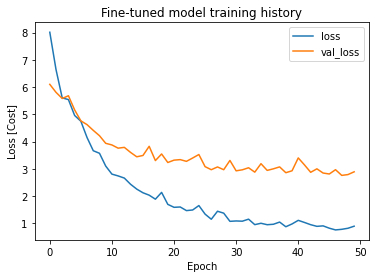

In [69]:
plt.plot(range(50),ft_hist.history['loss'], label='loss')
plt.plot(range(50),ft_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [Cost]')
plt.legend()
plt.title('Fine-tuned model training history')

In [82]:
test_results['visual_ft'] = ft.evaluate(test_ds,verbose=0)

Text(0.5, 1.0, 'Image model architecture comparison')

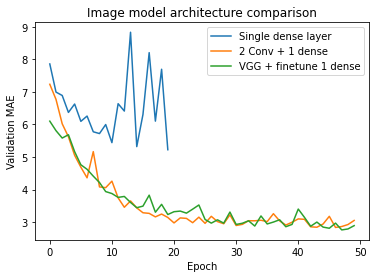

In [68]:
plt.plot(range(20),v_hist.history['val_MAE'], label='Single dense layer')
plt.plot(range(50),deepv_hist.history['val_MAE'],label='2 Conv + 1 dense')
plt.plot(range(50),ft_hist.history['val_MAE'],label='VGG + finetune 1 dense')
plt.xlabel('Epoch')
plt.ylabel('Validation MAE')
plt.legend()
plt.title('Image model architecture comparison')

## Compare numeric & visual models

Text(0.5, 1.0, 'Input data type performance comparison')

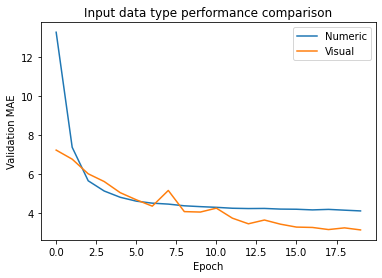

In [67]:
plt.plot(range(20),deeper_hist.history['val_MAE'],label='Numeric')
plt.plot(range(20),deepv_hist.history['val_MAE'][:20],label='Visual')
plt.xlabel('Epoch')
plt.ylabel('Validation MAE')
plt.legend()
plt.title('Input data type performance comparison')

In [83]:
test_results

{'bed_linear': [5.719838619232178, 5.719838619232178],
 'linear_all': [4.253116130828857, 4.253116130828857],
 'deeper_all': [4.0221147537231445, 4.0221147537231445],
 'visual_single': [5.224459171295166, 5.224459171295166],
 'visual_deep': [3.052748918533325, 3.052748918533325],
 'visual_ft': [2.8931641578674316, 2.8931641578674316]}